In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")


In [2]:
import acquire as acq
import prepare as prep

from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain
from acquire import get_telco_data
from prepare import DFO

In [3]:
local_settings.splain=True

In [4]:
local_settings.debug=True

In [5]:
splain = local_settings.splain
debug = local_settings.debug

In [6]:
    df = get_telco_data(splain=splain)
    df.set_index('customer_id')
    dfo = prep.set_dfo(dfo_df=df, y_column='churn', splain=True)


starting get_telco_data
starting sql_df
starting get_db_url
ending get_db_url ; time: 3.814697265625e-06
starting check_df
starting frame_splain
DATAFRAME SHAPE:
(7043, 39) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
is_male                     7043 non-null int64
senior_citizen              7043 non-null int64
partner                     7043 non-null int64
dependents                  7043 non-null int64
family                      7043 non-null int64
partner_deps_id             7043 non-null int64
partner_deps                7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null int64
multiple_lines              7043 non-null int64
phone_service_id            7043 non-null int64
phone_service_type          7043 non-null object
internet_service_type_id  

In [7]:
df = dfo.df

In [8]:
category_cols=[
    'partner_deps_id',
    'partner_deps',
    'gender',
    'contract_type_id',
    'internet_service_type_id',
    'internet_service_type',
    'contract_type',
    'payment_type_id',
    'payment_type',
    'phone_service_type',
    'phone_service_id'
]

category_cols

['partner_deps_id',
 'partner_deps',
 'gender',
 'contract_type_id',
 'internet_service_type_id',
 'internet_service_type',
 'contract_type',
 'payment_type_id',
 'payment_type',
 'phone_service_type',
 'phone_service_id']

In [9]:
for col in category_cols:
    df[col] = df[col].astype('category')
    

In [10]:
# df_dtypes = pd.DataFrame(df.dtypes).rename(columns={0:'dtype'}).reset_index()
# df_dtypes

In [11]:
# for row in np.arange(len(df_dtypes)):
#     if df_dtypes.loc[row, 'index'] in category_cols:
#         df_dtypes.loc[row, 'dtype'] = 'category'

# dict_dtypes = {}
# for row in np.arange(len(df_dtypes)):
#     dict_dtypes[df_dtypes.loc[row,'index']] = df_dtypes.loc[row, 'dtype'] 

# print(dict_dtypes)

In [12]:
# df = df.astype(dict_dtypes)

In [13]:
dfo.df = df

In [14]:
frame_splain(dfo.df, splain=True)

starting frame_splain
DATAFRAME SHAPE:
(7043, 39) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
customer_id                 7043 non-null object
gender                      7043 non-null category
is_male                     7043 non-null int64
senior_citizen              7043 non-null int64
partner                     7043 non-null int64
dependents                  7043 non-null int64
family                      7043 non-null int64
partner_deps_id             7043 non-null category
partner_deps                7043 non-null category
tenure                      7043 non-null int64
phone_service               7043 non-null int64
multiple_lines              7043 non-null int64
phone_service_id            7043 non-null category
phone_service_type          7043 non-null category
internet_service_type_id    7043 non-null category
internet_service_type       7043 non-null category
internet_service            7043 no

starting heatmap_train


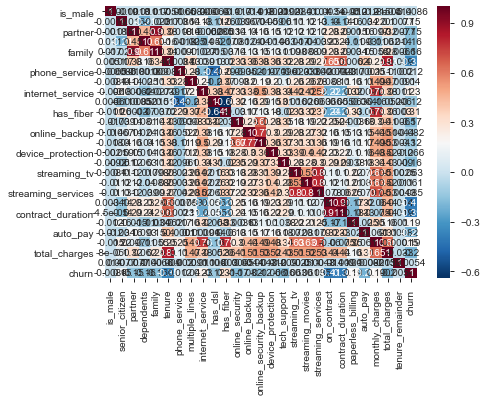

ending heatmap_train ; time: 3.235858917236328


In [15]:
prep.heatmap_train(df, show_now=True)

In [16]:
# prep.pairplot_train(df, show_now=True)

In [21]:
df[abs(df.tenure_remainder)>1]

,customer_id,gender,is_male,senior_citizen,partner,dependents,family,partner_deps_id,partner_deps,tenure,...,on_contract,contract_duration,paperless_billing,payment_type_id,payment_type,auto_pay,monthly_charges,total_charges,tenure_remainder,churn
16,0064-YIJGF,Male,1,0,1,1,1,3,"Has partner, has dependents",27,...,0,1,1,3,Bank transfer (automatic),1,75.75,1929.00,1.534653,0
18,0076-LVEPS,Male,1,0,0,1,1,1,"No partner, has dependents",29,...,0,1,1,2,Mailed check,0,45.00,1242.45,1.390000,0
20,0082-OQIQY,Male,1,0,0,0,0,0,"No partner, no dependents",29,...,0,1,1,1,Electronic check,0,94.20,2607.60,1.318471,0
21,0089-IIQKO,Female,0,0,1,1,1,3,"Has partner, has dependents",39,...,0,1,1,4,Credit card (automatic),1,99.95,3767.40,1.307154,0
23,0093-XWZFY,Male,1,0,0,0,0,0,"No partner, no dependents",40,...,0,1,1,4,Credit card (automatic),1,104.50,4036.85,1.369856,1
31,0111-KLBQG,Male,1,1,1,1,1,3,"Has partner, has dependents",32,...,0,1,1,2,Mailed check,0,93.95,2861.45,1.542842,0
61,0191-ZHSKZ,Male,1,1,0,0,0,0,"No partner, no dependents",30,...,0,1,1,1,Electronic check,0,74.75,2111.30,1.755184,0
66,0208-BPQEJ,Female,0,0,1,1,1,3,"Has partner, has dependents",12,...,0,1,0,3,Bank transfer (automatic),1,19.40,198.10,1.788660,0
68,0215-BQKGS,Male,1,0,0,0,0,0,"No partner, no dependents",30,...,0,1,1,4,Credit card (automatic),1,84.30,2438.60,1.072361,0
86,0257-ZESQC,Female,0,1,1,0,1,2,"Has partner, no dependents",27,...,0,1,1,3,Bank transfer (automatic),1,75.20,1929.35,1.343750,1


In [18]:
frame_splain(df, splain=True)

starting frame_splain
DATAFRAME SHAPE:
(7043, 39) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
customer_id                 7043 non-null object
gender                      7043 non-null category
is_male                     7043 non-null int64
senior_citizen              7043 non-null int64
partner                     7043 non-null int64
dependents                  7043 non-null int64
family                      7043 non-null int64
partner_deps_id             7043 non-null category
partner_deps                7043 non-null category
tenure                      7043 non-null int64
phone_service               7043 non-null int64
multiple_lines              7043 non-null int64
phone_service_id            7043 non-null category
phone_service_type          7043 non-null category
internet_service_type_id    7043 non-null category
internet_service_type       7043 non-null category
internet_service            7043 no

In [19]:
# type(df)